AM.R01CF.00.EHZ.D.2020.281 2020-10-20 11:54:43
1 Trace(s) in Stream:
AM.R01CF.00.EHZ | 2020-10-07T07:35:33.002999Z - 2020-10-07T07:40:33.002999Z | 100.0 Hz, 30001 samples

AM.R01CF.00.EHN.D.2020.281 2020-10-20 11:54:18
1 Trace(s) in Stream:
AM.R01CF.00.EHN | 2020-10-07T07:35:33.002999Z - 2020-10-07T07:40:33.002999Z | 100.0 Hz, 30001 samples

AM.R01CF.00.EHE.D.2020.281 2020-10-20 11:54:08
1 Trace(s) in Stream:
AM.R01CF.00.EHE | 2020-10-07T07:35:33.002999Z - 2020-10-07T07:40:33.002999Z | 100.0 Hz, 30001 samples



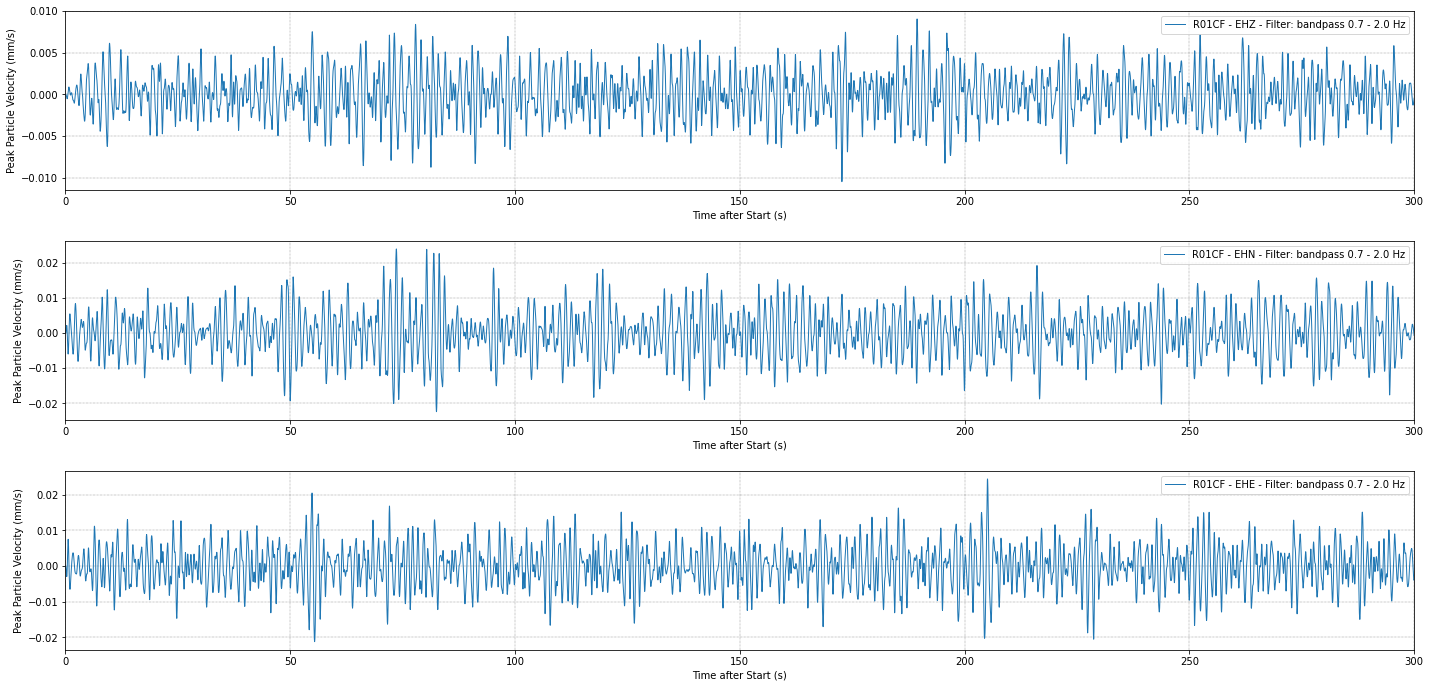

In [23]:
# offline version

from obspy.clients.fdsn import Client
from obspy import UTCDateTime, read_inventory, read
import matplotlib.pyplot as plt
import numpy as np
import datetime
import paramiko

### start user defined section ###

station = "R01CF" # code of the station

start_time = "2020-10-07T07:35:33.0000" # start time for the plot
end_time = "2020-10-07T07:40:33.0000" # end time for the plot

password = "yourpassword" # insert your password (default is 'shakeme')
username = "myshake"

f1 = 0.7 # high-pass filter corner
f2 = 2.0 # low-pass filter corner 
cor = 4 # number of corners

### end user defined section ###

# replace station name in nominal 'station.xml' response file for deconvolution
# read in the file
with open('station.xml', 'r') as file :
    filedata = file.read()

# replace the target string
filedata = filedata.replace('R01CF', station)

# write the file out again
with open('station.xml', 'w') as file:
    file.write(filedata)

# some time operations
year = start_time[:4]

start_time = UTCDateTime(start_time)
end_time = UTCDateTime(end_time)

day = start_time.strftime('%j')

# channel list
network = "AM"
channels = ["EHZ", "EHN", "EHE"]

# RS unit samples per second rate (100 sps or Hz)
freq = int(100)

# generate figure    
fig, axes = plt.subplots(figsize=(20, 10), nrows=3, ncols=1)
fig.tight_layout(pad=3.0)

# plot peak particle velocity charts for each channel of the RS3D unit    
for i, val in enumerate(channels):
    
    # connect to the Shake and download the relative mseed files
    host = "rs.local"
    port = 22
    transport = paramiko.Transport((host, port))
    
    transport.connect(username = username, password = password)

    sftp = paramiko.SFTPClient.from_transport(transport)
 
    sftp.chdir("/opt/data/archive/" + year + "/" + network + "/" + station + "/" + val + ".D/")
    
    for fileattr in sftp.listdir_attr():
        filetime = datetime.datetime.fromtimestamp(fileattr.st_mtime)
        filename = fileattr.filename
        
        if fileattr.filename.startswith('AM') and day in filename:
            print(filename, filetime)

            remotepath = "/opt/data/archive/" + year + "/" + network + "/" + station + "/" + val + ".D/" + filename
            localpath = "mseedfile_" + day + "_" + station + "_" + val
            sftp.get(remotepath, localpath)

    sftp.close()
    transport.close()    
    
    st = read("mseedfile_" + day + "_" + station + "_" + val, starttime=start_time, endtime=end_time)
    print(st)
    print("")
            
    # download and process waveforms for each channel            
    st.merge(method=0, fill_value='latest')
    st.detrend(type="demean")
    inv = read_inventory("station.xml")
    st.remove_response(inventory=inv, output="DISP")
    st.filter("bandpass", freqmin=f1, freqmax=f2, corners=cor)
    
    # beautify the plots            
    axes[i].plot(st[0].times(reftime=start_time), 2*np.pi*freq*st[0].data*1000, lw=1)
    axes[i].margins(x=0.0001)
    axes[i].grid(color='dimgray', ls = '-.', lw = 0.33)
    axes[i].set_ylabel("Peak Particle Velocity (mm/s)")
    axes[i].set_xlabel("Time after Start (s)")
    staleg = str(station + " - " + val + " - " + "Filter: bandpass " + str(f1) + " - " + str(f2) + " Hz") 
    axes[i].legend([staleg])
            
    # save the final figure
    plt.savefig("PPVMotion_" + station + ".png")